In [ ]:
%load_ext autoreload 
%autoreload 2

In [ ]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import Compose

In [ ]:
import torchvision

In [ ]:
from PIL import Image

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
import unet
from utils import roi
from utils import transforms as my_transforms

In [ ]:
from utils import dataset

In [ ]:
tsfms = Compose([
    my_transforms.Convert('I'),
    my_transforms.Resize(256, Image.BOX),
    my_transforms.DrawGrid(16),
    my_transforms.RandomHorizontalFlip(.5),
    my_transforms.RandomVerticalFlip(.5),
    my_transforms.ToTensor()
])

In [ ]:
ds = dataset.AnnotatedImages('/home/dhruv/Projects/cybergut/Data/', tsfms)

In [ ]:
dl = DataLoader(ds, 1, True, num_workers=2)

In [ ]:
try:
    next(iter(dl))
except FileNotFoundError:
    print("Not found")

In [ ]:
x, y = ds[1]

In [ ]:
x = x[None, :]
y = y[None, :]

In [ ]:
import utils

In [ ]:
utils.IoU(y, y)

In [ ]:
utils.IoU(y,y)

In [ ]:
from torch import nn

In [ ]:
l = nn.CrossEntropyLoss()

In [ ]:
y 

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
ds = torchvision.datasets.MNIST('/tmp', download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
dl = DataLoader(ds, batch_size=128, shuffle=True)

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
)

In [ ]:
test_ds = torchvision.datasets.MNIST('/tmp', train=False, transform=torchvision.transforms.ToTensor())
test_dl = DataLoader(test_ds, batch_size=128)

In [ ]:
optim = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def train(net, optim):
    loss_fn = torch.nn.CrossEntropyLoss()
    for i, (x, y) in enumerate(dl):
        optim.zero_grad()
        x = x.view(-1, 28*28)
        yp = net(x)
        loss = loss_fn(yp, y)
        loss.backward()
        optim.step()
        if (i % 99 == 0):
            print(loss)
            test_score()

In [ ]:
def train_for_cycle(net, optim, cycle_no, loss_fn):
    sched = CosineAnnealingLR(optim, 2**cycle_no*len(dl))
    history = []
    for i in range(2**cycle_no):
        for j, (x, y) in enumerate(dl):
            x = x.view(-1, 28*28)
            history.append(sched.get_lr())
            optim.zero_grad()
            yp = net(x)
            loss = loss_fn(yp, y)
            loss.backward()
            optim.step()
            sched.step()
            if j%100 == 99:
                print(loss)
    return history

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
hist2 = train_for_cycle(net, optim, 2, loss_fn)

In [ ]:
hist.extend(hist2)

In [ ]:
plt.plot(list(range(len(hist))), hist)

## Distance Map experiment

In [1]:
from utils import roi
import numpy as np
from skimage import draw, transform, io
import matplotlib.pyplot as plt
import cv2

In [2]:
polies = roi.get_polygons('../Data/Images/ROI/C - 1(fld 013 wv TL-Brightfield - dsRed).zip')

dists = []
oimg= np.zeros((2048, 2048), dtype=np.uint8)
for poly in polies:
    img = np.zeros((2048, 2048), dtype=np.uint8)
    xy = np.array(poly).T
    cv2.fillPoly(oimg, [xy], 255)
    xy = xy.reshape(-1, 1, 2)
    img = cv2.polylines(img, xy, True, 255, 3)
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    img  = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    img[img > 127] = 255
    img[img < 127] = 0
    img = 255 - img
    dst = cv2.distanceTransform(img, cv2.DIST_L2, 3)
    dists.append(dst)

In [3]:
oimg = cv2.resize(oimg, (512, 512), interpolation=cv2.INTER_AREA)
oimg[oimg < 127] = 0
oimg[oimg > 127] = 1
s = oimg.sum()
w0 = s/(2048*2048)
w1 = 1 - w0
wmapt = oimg*w1
wmapt[oimg == 0] = w0

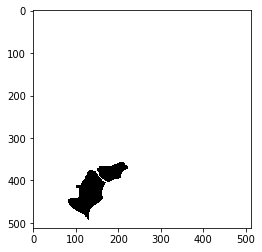

In [4]:
plt.imshow(wmapt, cmap='binary')
plt.show()

In [5]:
stk = np.stack(dists, -1)
stk.partition(1)
ws = stk[:, :, [0, 1]]
wmap = ws.sum(-1)
wmap = np.square(wmap, out=wmap)
wmap /= 50
wmap *= -1
wmap = 10*np.exp(wmap)
wmap += wmapt

In [6]:
fig, ax = plt.subplots(1, 1)
tmp = ax.imshow(wmap, cmap='jet')
fig.colorbar(tmp)
fig.savefig('/tmp/out.eps', format='eps', dpi=500)